In [118]:
import pandas as pd
import numpy as np
import re
from unicodedata import normalize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from utilities import plot_confusion_matrix
from collections import Counter, defaultdict
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import ExtraTreeClassifier
from yellowbrick.classifier import ClassificationReport
from sklearn.model_selection import ParameterGrid
from sklearn.multiclass import OneVsRestClassifier
#from sklearn.metrics import multilabel_confusion_matrix

In [119]:
df1 = pd.read_csv("C:\\Users\\utilisateur\\Documents\\Projet_ML_gr3\\data\\indeed_mongo.csv")
df = pd.read_csv("C:\\Users\\utilisateur\\Documents\\Projet_ML_gr3\\data\\indeed.pre_processing.csv")

In [120]:
dd = df[df["salaire_moyen"] != "None"]
(dd.isna().sum()/len(dd))*100

_id                          0.000000
adresse                      0.000000
date_de_publication          0.058685
description                  0.000000
localisation                 0.000000
nom_entreprise               0.000000
salaire                      0.000000
titre                        0.000000
type_de_contrat             35.211268
url                          0.000000
salaire_moyen                0.000000
niveau_etude                56.514085
Lyon                         0.000000
type_contrat_description    21.126761
Nantes                       0.000000
Paris                        0.000000
Toulouse                     0.000000
bac + 1                      0.000000
bac + 2                      0.000000
bac + 3                      0.000000
bac + 4                      0.000000
bac + 5                      0.000000
diplôme supérieur            0.000000
ingénieur                    0.000000
master 1                     0.000000
master 2                     0.000000
Apprentissag

Suppression des colonnes non dinaires

In [121]:
#col_to_drops = ["_id","adresse","date_de_publication","description","localisation","nom_entreprise","salaire","titre","type_de_contrat","url","niveau_etude","type_de_cursus","type_contrat_description","grande_categorie"]
col_to_drops = ["_id","adresse","date_de_publication","description","localisation","nom_entreprise","salaire","titre","type_de_contrat","url","niveau_etude","type_contrat_description"]
df = df.drop(col_to_drops, axis=1)

In [122]:
(df.isna().sum()/len(df))*100

salaire_moyen                                      0.0
Lyon                                               0.0
Nantes                                             0.0
Paris                                              0.0
Toulouse                                           0.0
bac + 1                                            0.0
bac + 2                                            0.0
bac + 3                                            0.0
bac + 4                                            0.0
bac + 5                                            0.0
diplôme supérieur                                  0.0
ingénieur                                          0.0
master 1                                           0.0
master 2                                           0.0
Apprentissage                                      0.0
Autre                                              0.0
CDD                                                0.0
CDI                                                0.0
Contrat pr

Creation du target 

In [132]:
Y_b = df[df["salaire_moyen"] != "None"]["salaire_moyen"]
X = df[df["salaire_moyen"] != "None"].drop(["salaire_moyen"], axis=1)

Trouver le meilleur nombre de cluster (classe possible)

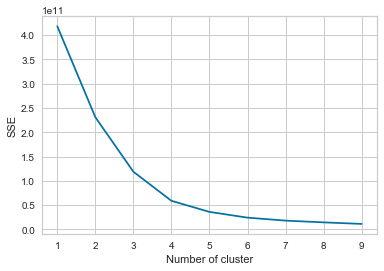

In [133]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k,init = 'k-means++', max_iter=1000).fit(Y_b.values.reshape(-1, 1))
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

Faire la prédiction des labels avec le meilleur KMeans trouvé précédement

In [136]:
kmeans = KMeans(n_clusters=4,init = 'k-means++', max_iter=1000).fit(Y_b.values.reshape(-1, 1))
y = kmeans.labels_
np.unique(y)
#y = label_binarize(y, classes=[0, 1, 2, 3])
#y = label_binarize(y, classes=[0, 1, 2, 3])
#print(y.shape)

array([0, 1, 2, 3])

(array([983.,   0.,   0., 566.,   0.,   0.,  43.,   0.,   0., 112.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

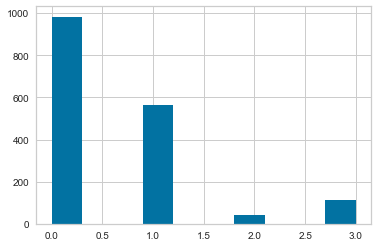

In [137]:
plt.hist(y)

In [138]:
centroid = kmeans.cluster_centers_
centroid.sort(axis = 0)
centre = list(centroid.reshape(1,-1)[0])
classe = [(centre[i]+centre[i+1])/2 for i in range(len(centre) - 1)]
classe_labels = []
for index, item in enumerate(classe):
    b = 0
    e = int(classe[index]/1000)
    if index > 0:
        b = int(classe[index-1]/1000)
    classe_labels.append("[{0}K - {1}K]".format(b,e))
classe_labels.append("[{0}K - {1}]".format(int(classe[len(classe)-1]/1000),"+"))
#classe_labels = ["[{0}K - {1}K]".format(classe[]) for item in classe]
print(classe_labels)
print(centre)
print(classe)

['[0K - 26K]', '[26K - 47K]', '[47K - 80K]', '[80K - +]']
[13984.674107142793, 39447.220752797526, 54922.93286219082, 107043.60465116276]
[26715.94742997016, 47185.07680749417, 80983.26875667679]


split data sklearn

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.25, random_state=0)

## Logistic Regression

In [140]:
lr = LogisticRegression()
parameters = [{'penalty': ['l2'],'C':[0.1,0.6,1,5,10,25],
              'multi_class':['ovr', 'multinomial'],'class_weight':['balanced', None],
              'solver':['lbfgs','newton-cg'],'max_iter':[1000]},
              {'penalty': ['l1','l2'],'C':[0.1,0.6,1,5,10,25],
              'multi_class':['ovr'],'class_weight':['balanced', None],
              'solver':['liblinear'],'max_iter':[1000]},{'penalty': ['l1','l2'],'C':[0.1,0.6,1,5,10,25],
              'multi_class':['ovr', 'multinomial'],'class_weight':['balanced', None],
              'solver':['saga'],'max_iter':[1000]}]

#multinomial is like softmax
#ovr : on vs the rest
#lbfgs : gestion de memoire durant le DG (descebte de gradient)
#https://stackoverflow.com/questions/42424444/scipy-optimisation-newton-cg-vs-bfgs-vs-l-bfgs
#newton-cg : ??
#liblinear : LIBLINEAR is a linear classifier for data with millions of instances and features.
#https://www.csie.ntu.edu.tw/~cjlin/liblinear/
#If the option chosen is ‘ovr’, then a binary problem is fit for each label. 
#For ‘multinomial’ the loss minimised is the multinomial loss fit across the entire probability distribution,
#even when the data is binary. ‘multinomial’ is unavailable when solver=’liblinear’. 
#‘auto’ selects ‘ovr’ if the data is binary, or if solver=’liblinear’, and otherwise selects ‘multinomial’.
#https://stats.stackexchange.com/questions/212053/difference-between-multinomial-and-one-vs-rest-schemes-in-logistic-regression

clf = GridSearchCV(lr, param_grid = parameters, return_train_score=True, n_jobs=-1)
clf.fit(X_train, y_train)
result = pd.DataFrame.from_dict(clf.cv_results_)
#Predict values based on new parameters
y_pred = clf.predict(X_test)

C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [231]:
#result

In [145]:
type(clf.best_estimator_)

sklearn.linear_model.logistic.LogisticRegression

In [111]:
import sklearn.metrics as metrics
from sklearn.preprocessing import OneHotEncoder
#y_pred_proba = clf.predict_proba(X_test)[::,1]
ohe = OneHotEncoder(sparse=False)
y_test1 = ohe.fit_transform(y_test.reshape(-1, 1))
print(y_test1.shape)
fpr, tpr, _ = metrics.roc_curve(y_test1,  y_pred)
auc = metrics.roc_auc_score(y_test1, y_pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

(426, 4)


C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


ValueError: multilabel-indicator format is not supported

In [89]:
#print(y_test)
y_test1 = label_binarize(y_test, classes=[0, 1, 2, 3])
print(y_test1)

[[0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 ...
 [1 0 0 0]
 [1 0 0 0]
 [0 0 0 1]]


C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


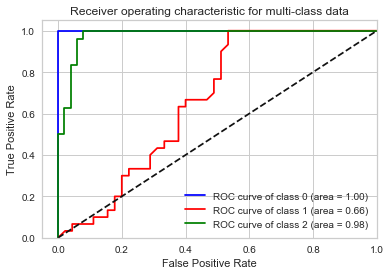

In [144]:
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

iris = datasets.load_iris()
X = iris.data
y = iris.target

# Binarize the output
y_roc_auc = label_binarize(y, classes=[0, 1, 2,3])
n_classes = y_roc_auc.shape[1]

lr_roc_auc = LogisticRegression(C=0.6, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

X_train, X_test, y_train, y_test = train_test_split(X, y_roc_auc, test_size=.5, random_state=0)
classifier = OneVsRestClassifier(lr_roc_auc)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


In [90]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test1, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# method II: ggplot
from ggplot import *
df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
ggplot(df, aes(x = 'fpr', y = 'tpr')) + geom_line() + geom_abline(linetype = 'dashed')

ValueError: multilabel-indicator format is not supported

**Accuracy**

In [30]:
print(metrics.accuracy_score(y_test, y_pred))

0.7089201877934272


 **Train vs Test plot**

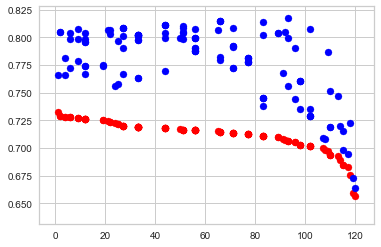

In [31]:
plt.scatter(result['rank_test_score'],result['mean_test_score'],color='red')
plt.scatter(result['rank_test_score'],result['mean_train_score'],color='blue')

**Classification Report**

C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


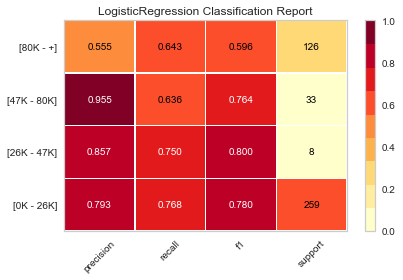

In [32]:
viz = ClassificationReport(lr, classes=classe_labels, support=True)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
g = viz.poof()

**Matrice de confusion**

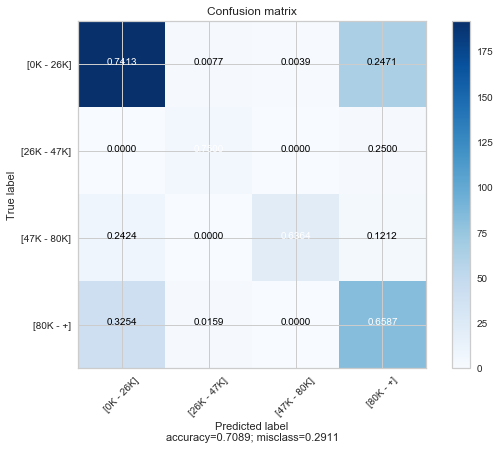

In [33]:
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classe_labels)

## Support-vector machine

In [34]:
model = SVC()
hyperparameters = [
  {'C': [0.1,0.6,1,5,10,25],'class_weight':['balanced', None],
   'gamma': ['scale','auto'], 'kernel': ['linear'], 'decision_function_shape': ['ovo', 'ovr']},
  {'C': [0.1,0.6,1,5,10,25], 'class_weight':['balanced', None],
   'gamma': ['scale','auto'], 'kernel': ['rbf'], 'decision_function_shape': ['ovo', 'ovr']},
  {'C': [0.1,0.6,1,5,10,25], 'class_weight':['balanced', None],
   'gamma': ['scale','auto'], 'kernel': ['poly'], 'degree': [2,3,4,5,6,7],
     'decision_function_shape': ['ovo', 'ovr']},
  {'C': [0.1,0.6,1,5,10,25],'class_weight':['balanced', None],
   'gamma': ['scale','auto'], 'kernel': ['sigmoid'], 'decision_function_shape': ['ovo', 'ovr']}
 ]
#C = 1/λ : Large C -> moins de bias mais plus de variance (tendance d'overfitting)
#          Petit C -> plus de bias mais moins de variance (tendance d'underfitting)
#https://www.quora.com/What-are-C-and-gamma-with-regards-to-a-support-vector-machine
#Pourquoi utiliser C sans préciser de pénalité L1 ou L2 ?
#Gamma : large gamma leads to high bias and low variance models, and vice-versa.
#Gamma scale ? 
#scale auto ?
#decision_function_shape ?
clf_SVM = GridSearchCV(model, param_grid = hyperparameters, return_train_score=True, n_jobs=-1)
clf_SVM.fit(X_train, y_train)
result_SVM = pd.DataFrame.from_dict(clf_SVM.cv_results_)
#Predict values based on new parameters
y_pred_SVM = clf_SVM.predict(X_test)

C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [35]:
clf_SVM.best_estimator_

SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

**Accuracy**

In [36]:
print(metrics.accuracy_score(y_test, y_pred_SVM))
#Démontrer pourquoi le Kernel est plus précis avec Logistic et SVM linéaire 

0.8309859154929577


 **Train vs Test plot**

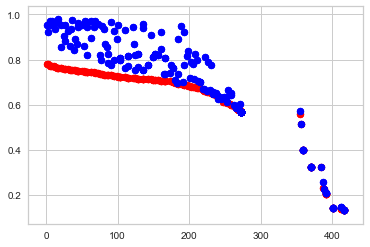

In [37]:
plt.scatter(result_SVM['rank_test_score'],result_SVM['mean_test_score'],color='red')
plt.scatter(result_SVM['rank_test_score'],result_SVM['mean_train_score'],color='blue')

**Classification Report**

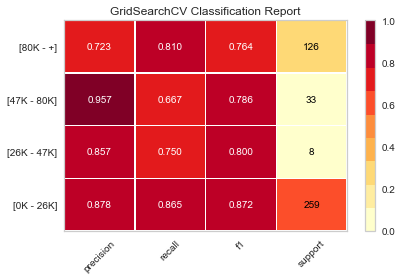

In [38]:
viz = ClassificationReport(clf_SVM, classes=classe_labels, support=True)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
g = viz.poof()

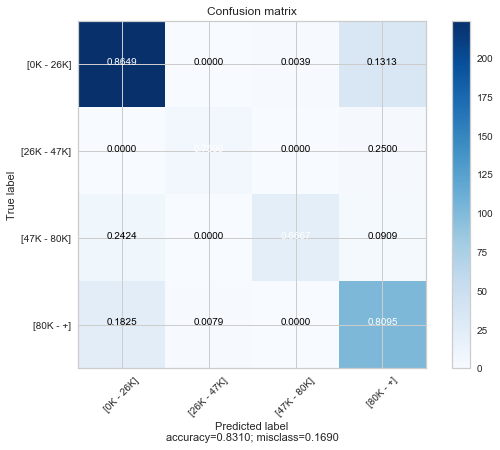

In [39]:
cm = metrics.confusion_matrix(y_test, y_pred_SVM)
plot_confusion_matrix(cm, classe_labels)

## Random Forest Classifier

In [242]:
model = RandomForestClassifier()
hyperparameters = {'n_estimators': [10,50,100,150,200],
                   "criterion": ["gini", "entropy"],
                   "max_depth": [3, 5, None],
                   "min_samples_split": [2, 3, 5, 10],
                   "max_features": ["auto", "sqrt", "log2", None],
                   "bootstrap": [True, False],
                   "class_weight": ["balanced", "balanced_subsample", None]
                  }
#n_estimators number of tree
#criterion : gini ou entropy sont des indices pour mésurer la purité d'une variable avant division
#max_depth : nombre de division possible. None implique que les divisions vont se poursuivre jusqu'à la valeur  min_samples_split
#max_features : C'est le maximum de features qu'on prend lorsqu'on crée les arbres dû au Boostrap sample
clf_RFC = GridSearchCV(model, param_grid = hyperparameters, return_train_score=True, n_jobs=-1)
clf_RFC.fit(X_train, y_train)
result_RFC = pd.DataFrame.from_dict(clf_RFC.cv_results_)
#Predict values based on new parameters
y_pred_RFC = clf_RFC.predict(X_test)

C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [243]:
clf_RFC.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

**Accuracy**

In [244]:
print(metrics.accuracy_score(y_test, y_pred_RFC))

0.8004694835680751


 **Train vs Test plot**

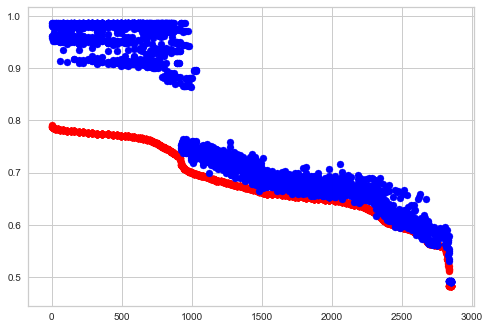

In [245]:
plt.scatter(result_RFC['rank_test_score'],result_RFC['mean_test_score'],color='red')
plt.scatter(result_RFC['rank_test_score'],result_RFC['mean_train_score'],color='blue')

**Classification Report**

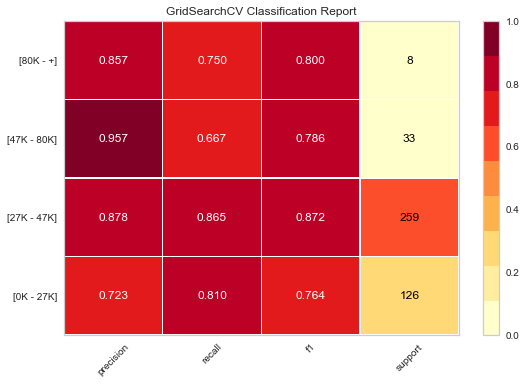

In [246]:
viz = ClassificationReport(clf_SVM, classes=classe_labels, support=True)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
g = viz.poof()

**Matrice de confusion**

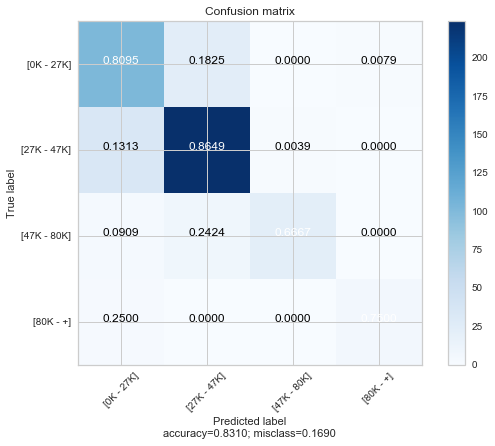

In [247]:
cm = metrics.confusion_matrix(y_test, y_pred_SVM)
plot_confusion_matrix(cm, classe_labels)

## AdaBoost: decision tree et extra tree

In [45]:
#https://fr.wikipedia.org/wiki/AdaBoost
model = AdaBoostClassifier()
hyperparameters = {'base_estimator': [None,
                                      DecisionTreeClassifier(max_depth = 2),
                                      DecisionTreeClassifier(max_depth = 5),
                                      DecisionTreeClassifier(max_depth = 10),
                                      ExtraTreeClassifier(max_depth = 1),
                                      ExtraTreeClassifier(max_depth = 2),
                                      ExtraTreeClassifier(max_depth = 5),
                                      ExtraTreeClassifier(max_depth = 10)
                                      ],                   
                   'n_estimators': [100,150,200,250,300],
                   'learning_rate' : [0.1,0.3],
                   'algorithm' : ['SAMME', 'SAMME.R']
                  }
clf_Ada_tree = GridSearchCV(model, param_grid = hyperparameters, return_train_score=True, error_score='raise', n_jobs=-1)
clf_Ada_tree.fit(X_train, y_train)
result_Ada_tree = pd.DataFrame.from_dict(clf_Ada_tree.cv_results_)
#Predict values based on new parameters
y_pred_Ada_tree = clf_Ada_tree.predict(X_test)
result_Ada_tree.to_csv("result_Ada_tree.csv", index = False)

C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [47]:
clf_Ada_tree.best_estimator_

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, random_state=None,
          splitter='random'),
          learning_rate=0.1, n_estimators=200, random_state=None)

**Accuracy**

In [48]:
print(metrics.accuracy_score(y_test, y_pred_Ada_tree))

0.852112676056338


 **Train vs Test plot**

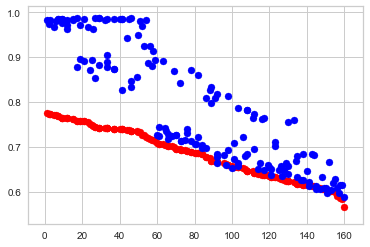

In [49]:
plt.scatter(result_Ada_tree['rank_test_score'],result_Ada_tree['mean_test_score'],color='red')
plt.scatter(result_Ada_tree['rank_test_score'],result_Ada_tree['mean_train_score'],color='blue')

**Classification Report**

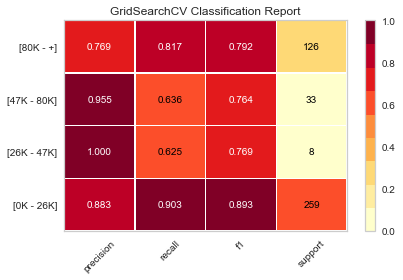

In [50]:
viz = ClassificationReport(clf_Ada_tree, classes=classe_labels, support=True)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
g = viz.poof()

**Matrice de confusion**

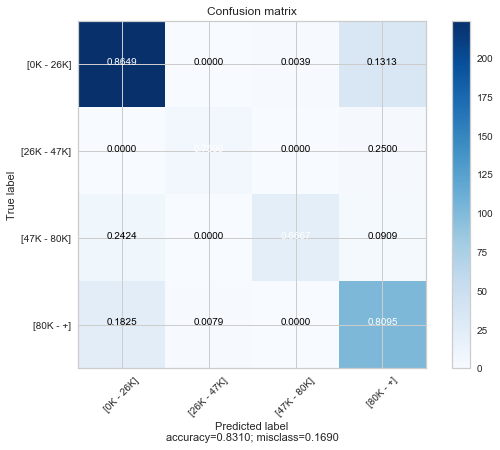

In [51]:
cm = metrics.confusion_matrix(y_test, y_pred_SVM)
plot_confusion_matrix(cm, classe_labels)

## AdaBoost: random forest et extra trees

In [67]:

model = AdaBoostClassifier()
model1 = RandomForestClassifier()
hyperparameters1 = {'n_estimators': [100,150,200],
                   "criterion": ["entropy"],
                   "max_depth": [2, 5, 10],
                   "max_features": ["auto", "log2", None],
                  }
clf = RandomForestClassifier()
base_est_ran = [clf.set_params(**ele) for ele in ParameterGrid(hyperparameters1)]
hyperparameters = {'base_estimator': base_est_ran,                   
                   'n_estimators': [100,150,200,250,300],
                   'learning_rate' : [0.1,0.3],
                   'algorithm' : ['SAMME', 'SAMME.R']
                  }
clf_Ada_ran = GridSearchCV(model, param_grid = hyperparameters, return_train_score=True, error_score='raise', n_jobs=-1)
clf_Ada_ran.fit(X_train, y_train)
result_Ada_ran = pd.DataFrame.from_dict(clf_Ada_ran.cv_results_)
#Predict values based on new parameters
y_pred_Ada_ran = clf_Ada_ran.predict(X_test)
result_Ada_ran.to_csv("result_Ada_ran.csv", index = False)

C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


KeyboardInterrupt: 

In [ ]:
clf_Ada_ran.best_estimator_

**Accuracy**

In [ ]:
print(metrics.accuracy_score(y_test, y_pred_Ada_tree))

**Train vs Test plot**

In [ ]:
plt.scatter(result_Ada_tree['rank_test_score'],result_Ada_tree['mean_test_score'],color='red')
plt.scatter(result_Ada_tree['rank_test_score'],result_Ada_tree['mean_train_score'],color='blue')

**Classification Report**

In [ ]:
viz = ClassificationReport(clf_Ada_ran, classes=classe_labels, support=True)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
g = viz.poof()

**Matrice de confusion**

In [ ]:
cm = metrics.confusion_matrix(y_test, y_pred_SVM)
plot_confusion_matrix(cm, classe_labels)

Pourquoi on arrive à faire une bonne prédiction pour les valeur [27K - 47K] à 75% ? 
Pourquoi on a 30% de confusion de la classe [0 - 27K] à la [27K - 47K] ? 
Pourquoi on a 20% de confusion de la classe [27K - 47K] à la [0K - 47K] ? 

In [ ]:
#print(Counter(kmeans.labels_))
#kmeans.labels_[1].values
cluster_map = pd.DataFrame()
cluster_map['salaire_moyen'] = Y_b
cluster_map['cluster'] = kmeans.labels_
cluster_map[cluster_map.cluster == 0]